코랩에서 바로 열기:
<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/Insight-Sogang-Univ/insight-14th/blob/main/advanced/template/session04/assignment_Transformer.ipynb" target="_parent">
      <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
  </td>
</table>


# Transforemr를 활용한 챗봇 구현

---

### 목차

---

- **Part 0**: 준비 단계 (환경 설정, 라이브러리 로드, Transformer 개념)
- **Part 1**: 모델의 기본 구성 요소 정의
- **Part 2**: 인코더 - 디코더 구조 구성
- **Part 3**: 전체 Transformer 모델 빌드
- **Part 4**: 학습 준비 및 모델 학습
- **Part 5**: 챗봇 구현 & 결과 테스트



---

# 0. 준비 단계 (환경 설정, 라이브러리 로드, Transformer 개념)

## 0-1. 환경 설정, 라이브러리 로드

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import urllib.request
import time
import matplotlib.pyplot as plt
import re

In [16]:
# Tensorflow 버전 확인

tf.__version__

'2.19.0'

**tensorflow**는 아는데, **tensorflow_datasets**가 뭔지 궁금하실 수 있을 것 같아요. \
**tensorflow_datasets**(tfds)란, 공개 데이터셋을 쉽게 로드할 수 있도록 해주는 라이브러리예요.

- 번역 데이터셋, 텍스트 데이터, 이미지 등을 가져올 수 있고
- 훈련/검증, `split`, `batch`, `shuffle` 처리가 가능하도록 해주고
- TensorFlow용 입력 파이프라인을 생성해줍니다.

이 과제에서는 **트랜스포머 학습용 텍스트 데이터셋**을 불러오고, **토큰화/전처리**를 편리하게 하기 위해 사용합니다!

## 0-2. Transformer 개념

트랜스포머는 **문장의 의미 + 단어 간 관계 + 단어 순서 정보**를  
Self-Attention 메커니즘으로 학습하여 문장을 이해하고 생성합니다.

---

### 🌈 1) 단어 + 위치 정보

트랜스포머는 RNN처럼 순서대로 처리하지 않기 때문에  
**단어 의미 + 위치 정보**를 함께 제공합니다.

- **Embedding:** 단어 의미 벡터화  
- **Positional Encoding:** 사인/코사인 패턴으로 위치 정보 부여
---

### 👁 2) Self-Attention

각 단어가 문장 속 다른 단어들과 연결되며 의미를 파악합니다.

**Query (Q)**  : 무엇을 찾는가 \
**Key (K)**    : 어떤 정보를 갖는가 \
**Value (V)**  : 실제 정보


간단 수식:

Attention = (Q × Kᵀ / √d) → 중요도 계산 → Value 가중합

---

### 🧠 3) Multi-Head Attention

하나의 기준으로만 보는 것이 아니라  
**여러 관점**에서 **동시에** 문장을 바라봅니다.


관점1: 문법
관점2: 의미
관점3: 긴 거리 관계
...  
→ 합치기



> **블록 개념**:

> [Q]　[K]　[V]  
> ↓ 　 　↓　 　↓  
> [👁] [👁] [👁] ... (여러 헤드)  
> 　　　↓  
> 　**Concat**  
> 　　　↓  
> 　**선형 변환**  

---

### 🏗️ 4) Encoder / Decoder 역할

| Encoder | Decoder |
|--------|--------|
입력을 이해합니다 | 다음 단어를 생성합니다 |
Self-Attention | Masked Self-Attention + Cross-Attention |
전체 문장 참조 | 미래 단어는 못 봄 (Look-Ahead Mask) |

---

### 🎯 핵심 요약

| 구성 요소 | 역할 |
|---|---|
📦 Embedding | 단어 의미 표현  
🌈 Positional Encoding | 위치 정보 제공  
👁 Self-Attention | 단어 간 관계 계산  
🧠 Multi-Head Attention | 다양한 관점 통합  
🏗 Encoder | 입력 문장 이해  
📤 Decoder | 문장 생성  
🚫 Mask | 패딩 무시 & 미래 차단  

---

즉, 트랜스포머는 이렇게 정리됩니다:

> **"단어들이 서로를 바라보며,  
> 여러 관점에서 의미를 계산하고,  
> 위치까지 고려해 문장을 이해하고 만든다."**

# 1. 모델의 기본 구성 요소 정의

## 1-1. Positional Encoding

### Positional Encoding 정의하기

In [17]:
# Positional Encoding 클래스를 정의합니다.
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)  # 최대 길이와 모델 차원 넣었었죠

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles  # position과 angle을 곱해 각 위치별 주파수 생성

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
      position = tf.range(position, dtype=tf.float32)[:, tf.newaxis],
      i = tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
      d_model=d_model)  # 모델 차원 전달

    # 배열의 짝수 인덱스(2i)에는 사인 함수를 적용합니다.
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수를 적용합니다.
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sines와 cosines를 교차 결합합니다.
    interleaved_parts = tf.stack([sines, cosines], axis=-1)
    pos_encoding = tf.reshape(interleaved_parts, [position, d_model])  # 마지막 차원 d_model이 들어가요

    pos_encoding = pos_encoding[tf.newaxis, ...]

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]  # 입력 토큰 길이만큼 위치 인코딩 더해요


### Positional Encoding 시각화하기

- **가로축 (depth)**
    - 임베딩 벡터의 차원 (128 차원)
- **세로축 (position)**
    - 토큰의 순서 (문장에서의 n번째 단어)
- **색상**: 해당 위치와 차원에서의 positional encoding값
    - 빨강: 양수 값
    - 파랑: 음수 값

(1, 50, 128)


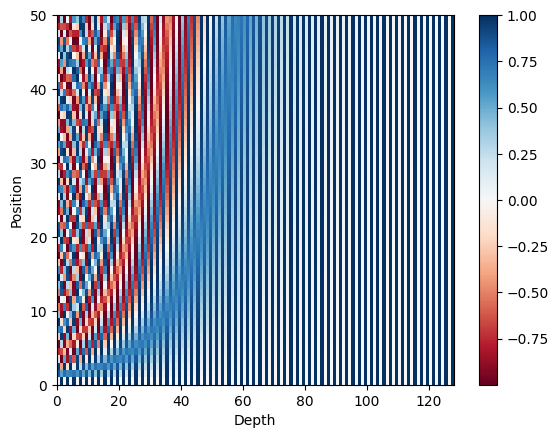

In [19]:
sample_pos_encoding = PositionalEncoding(50, 128)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

**해석 포인트**

1. **왼쪽** 부분의 촘촘한 주기
    - 낮은 depth(차원)일수록 사인/코사인 주기가 짧고 빠르게 진동합니다. \
        -> 모델이 가까운 위치 간 미세한 순서 차이를 정밀하게 인지할 수 있습니다.

2. **오른쪽**으로 갈수록 느려지는 파형
    - 높은 depth일수록 더 긴 주기를 가지며, 완만한 진동 형태를 보입니다. \
        -> 문장에서 멀리 떨어진 단어들 간의 관계, 즉 장기 의존성을 포착하는게 기여합니다.

3. **위쪽**일수록 점점 phase가 변함
    - 위치가 커질수록(문장 뒤로 갈수록) 값도 점진적으로 변합니다. \
        -> 토큰의 위치가 증가할 때마다 위상(phase)가 연속적으로 변화하므로, 모델이 각 단어의 절대적 위치뿐 아니라 상대적 위치 관계까지 추론할 수 있는 기반을 제공합니다.

## 1-2. Scaled Dot-Product Attention

- **Query (Q)**: `(batch_size, num_heads, query_length, d_model/num_heads)` \
  → 현재 토큰이 어떤 정보를 찾으려 하는지 표현합니다.

- **Key (K)**: `(batch_size, num_heads, key_length, d_model/num_heads)` \
  → 전체 문장에서 비교 기준 역할을 합니다. (Q가 어느 위치를 볼지 결정)

- **Value (V)**: `(batch_size, num_heads, value_length, d_model/num_heads)` \
  → 실제로 가져올 정보입니다. (어텐션으로 weighted sum)

- **Padding Mask**: `(batch_size, 1, 1, key_length)` \
  → 패딩 토큰 위치를 마스킹해 softmax에서 제외합니다.


In [20]:
def scaled_dot_product_attention(query, key, value, mask):

  # Q와 K의 곱. 어텐션 스코어 행렬을 만듭니다.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링: depth의 루트값으로 나눠줍니다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹: 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣어줍니다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 됩니다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행됩니다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

## 1-3. Multi-Head Attention

### Multi-Head Attention 클래스 정의하기

여기서 잠깐!
밀집층(Dense Layer) vs 은닉층(Hidden Layer)

- **밀집층(Dense Layer)**  
  입력 노드와 출력 노드가 모두 서로 연결된 신경망 층을 의미합니다.  
  각 노드는 모든 입력에 대해 가중합 연산을 수행하고, 활성화 함수를 통해 변환합니다.  
  즉, 특정한 연산 방식(완전 연결 방식)을 가진 **층의 형태**를 나타냅니다.

- **은닉층(Hidden Layer)**  
  입력층과 출력층 사이에 위치한 모든 층을 의미합니다.  
  모델 내부에서 특징을 학습하는 역할을 하며, 모델의 깊이를 구성합니다.  
  즉, 신경망 구조 안에서 **위치와 역할**을 나타냅니다.



> **정리**
> - 밀집층은 **완전 연결된 연산 방식**을 말합니다.  
> - 은닉층은 **네트워크 내부에 위치한 층**을 말합니다.  
> - 따라서 은닉층이면서 밀집층일 수도 있습니다.


In [87]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값입니다.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층을 정의합니다.
    self.query_dense = tf.keras.layers.Dense(units=d_model)  # WQ 출력 차원은 모델 차원과 동일했어요
    self.key_dense = tf.keras.layers.Dense(units=d_model)    # WK 출력 차원도 동일
    self.value_dense = tf.keras.layers.Dense(units=d_model)  # WV 출력 차원도 동일

    # WO에 해당하는 밀집층을 정의합니다.
    self.dense = tf.keras.layers.Dense(units=d_model)  # 헤드 결합 후 최종 투영 차원

  # num_heads 개수만큼 q, k, v를 split하는 함수를 정의합니다.
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))  # head 수와 depth로 분해 (num_heads, depth)
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. 입력 텐서에 대해 WQ, WK, WV에 해당하는 밀집층을 적용합니다.
    #    이 과정을 통해 원본 임베딩을 어텐션 연산에 적합한 형태의 Query, Key, Value로 변환합니다.
    #    query, key, value는 각각 (batch_size, 문장 길이, d_model) 형태를 가집니다.
    #    인코더-디코더 어텐션에서는 q의 길이와 k, v의 길이가 다를 수 있습니다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

     # 2. 여러 헤드(head)로 분리합니다.
    #    이를 통해 어텐션을 서로 다른 관점에서 병렬적으로 계산합니다.
    #    결과 텐서는 (batch_size, num_heads, 문장 길이, d_model/num_heads) 형태가 됩니다.
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션을 계산합니다.
    #    Query와 Key를 통해 어텐션 스코어를 구하고, 해당 스코어를 기반으로 Value를 가중합합니다.
    #    마스크(mask)가 있는 경우 패딩 또는 미래 토큰을 보지 않도록 차단합니다.
    #    반환되는 텐서는 (batch_size, num_heads, 문장 길이, d_model/num_heads) 형태입니다.
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 병렬 계산된 여러 헤드를 다시 하나로 합칩니다.
    #    이를 위해 (batch_size, num_heads, 문장 길이, depth)에서
    #    (batch_size, 문장 길이, num_heads, depth)로 transpose 후,
    #    (batch_size, 문장 길이, d_model)로 reshape 합니다.
    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # num_heads*depth = d_model

    # 5. 최종 출력을 얻기 위해 WO에 해당하는 밀집층을 한 번 더 통과시킵니다.
    #    이 단계에서 각 헤드의 정보가 통합되어 최종 어텐션 결과가 됩니다.
    outputs = self.dense(concat_attention)

    return outputs


### Padding Mask 생성하기

- 입력 시퀀스에서 `0`(패딩 토큰) 위치를 찾아 마스크를 만듭니다.  
- 패딩(마스킹) 위치는 `1`, 실제 단어 위치는 `0`으로 표시합니다.  
- 이 마스크는 어텐션 연산 시 패딩 토큰에 주의를 주지 않도록 차단하는 데 사용됩니다.  
- 출력 형태는 `(batch_size, 1, 1, key_length)`가 되어 모든 헤드와 모든 query 위치에 동일하게 적용됩니다.

In [23]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :]

# 2. 인코더 - 디코더 구성하기

## 2-1. Encoder Layer

이 레이어는 트랜스포머 인코더의 기본 구성 단위입니다.  
하나의 인코더 블록은 아래 두 단계로 이루어집니다.

1. **Self-Attention 서브층**
   - Query = Key = Value = 입력 토큰 임베딩
   - 패딩 마스크를 사용하여 의미 없는 패딩 토큰을 무시합니다
   - Dropout → Residual Connection → Layer Normalization 순서로 안정적으로 학습합니다

2. **Feed-Forward 서브층**
   - 각 토큰 위치마다 독립적으로 작은 MLP를 적용합니다
   - 비선형 변환(ReLU) 후 다시 d_model 차원으로 투영합니다
   - Dropout → Residual Connection → Layer Normalization을 동일하게 적용합니다

출력은 입력과 동일한 shape `(batch_size, sequence_length, d_model)`을 유지합니다.  
이를 여러 층 쌓아 인코더가 문맥 표현을 깊게 학습하도록 합니다.


In [43]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더에서는 패딩 위치를 무시하기 위해 패딩 마스크를 사용합니다.
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 1) 멀티-헤드 셀프 어텐션을 수행합니다.
  #    Query, Key, Value 모두 동일한 입력을 사용하므로 self-attention이 됩니다.
  #    이를 통해 문장 안의 토큰들이 서로 어떤 관계가 있는지 학습합니다.
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V (self-attention)
          'mask': padding_mask # 패딩 토큰은 어텐션 계산에서 제외합니다.
      })

  # 어텐션 결과에 드롭아웃을 적용하여 과적합을 방지합니다.
  # 이후 입력과 더해 residual 연결을 수행하고, Layer Normalization을 적용합니다.
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 2) 위치별 Feed-Forward 네트워크를 적용합니다.
  #    각 토큰 위치마다 독립적으로 작은 MLP를 적용하여 비선형 변환을 수행합니다.
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention) # 활성화 함수는 relu를 사용합니다.
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # Feed-Forward 결과에도 Attention과 같이 Dropout → Residual 연결 → Layer Normalization 순으로 적용합니다.
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  # 구성된 인코더 서브 레이어를 반환합니다.
  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


## 2-2. Encoder 구성

트랜스포머의 전체 Encoder를 구성합니다.

- 입력 토큰을 임베딩하고 위치 정보를 더합니다  
- 패딩 토큰을 무시하기 위해 padding mask를 사용합니다  
- `encoder_layer` 를 `num_layers` 만큼 쌓아 문장 전체의 문맥 정보를 학습할 수 있도록 합니다  

출력은 각 토큰이 다른 모든 토큰을 참조한 **문맥 표현(Context Representation)** 입니다.


In [29]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 입력 시퀀스에서 패딩 위치를 무시하기 위해 패딩 마스크를 사용합니다.
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 1) 임베딩: 토큰을 d_model 차원의 벡터로 변환합니다.
  #    스케일링: 임베딩 값의 크기를 조정하여 안정적 학습을 돕습니다.
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # PositionalEncoding은 Dense 텐서를 기대하므로 identity로 명시합니다.
  embeddings = tf.keras.layers.Lambda(lambda x: tf.identity(x), name='dense_embedding_encoder')(embeddings)

  # 2) 포지셔널 인코딩: 단어들의 위치 정보를 더해 순서를 학습하게 합니다.
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(embeddings)

  # 3) 드롭아웃 적용: 과적합을 방지합니다.
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 4) 인코더 레이어를 num_layers만큼 반복하여 쌓습니다.
  #    각 레이어는 Self-Attention + FFN 구조로 구성됩니다.
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads, # 인코더에 들어가는 d_model, num_heads는 각각 뭘까요?
        dropout=dropout, name=f"encoder_layer_{i}", # 레이어 이름을 유니크하게 지정합니다.
    )([outputs, padding_mask])

  # 최종적으로 문장 내 모든 토큰의 문맥 정보를 출력합니다.
  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


## 2-3. Look-Ahead Mask 생성

디코더는 다음 단어를 한 번에 미리 볼 수 없습니다.  
따라서 **미래 위치를 가리는 Look-Ahead Mask**를 사용합니다.

- 현재 시점 이후의 토큰을 차단하여  
  **모델이 미래 단어를 엿보지 못하게 합니다**
- 동시에 **패딩 마스크도 함께 적용**하여  
  의미 없는 패딩 토큰을 무시합니다

출력은 `(batch_size, 1, seq_len, seq_len)` 형태의 마스크입니다.


In [30]:
# 디코더의 첫 번째 서브층에서 미래 토큰을 Mask하는 함수입니다.
# 디코더는 미래 단어를 미리 보면 안 되므로, 자기 이후의 위치를 가립니다.
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]   # 입력 시퀀스 길이를 가져옵니다 (예: 10개의 토큰)

  # Look-Ahead Mask를 생성합니다.
  # band_part를 이용해 아래 삼각 행렬만 남기고, 나머지를 1로 만들어 미래를 차단합니다.
  # 예:
  # [[0,1,1],
  #  [0,0,1],
  #  [0,0,0]]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

  # 패딩 위치도 함께 마스킹합니다 (padding 토큰은 어텐션에서 제외합니다).
  padding_mask = create_padding_mask(x)

  # 두 마스크 중 더 큰 값을 선택하여 미래 + 패딩을 동시에 차단합니다.
  return tf.maximum(look_ahead_mask, padding_mask)


## 2-4. Decoder Layer

디코더 레이어는 한 단계의 디코더 블록을 구성합니다.  
총 세 개의 서브층으로 이루어져 있습니다.

1) **Masked Self-Attention**
   - 현재 시점 이후 토큰을 보지 않도록 Look-Ahead Mask를 적용합니다.

2) **Encoder-Decoder Cross Attention**
   - 인코더에서 나온 문맥 정보(encoder outputs)를 참고하여 다음 단어를 예측합니다.
   - Padding Mask를 사용해 패딩 위치는 무시합니다.

3) **Position-wise Feed-Forward Network**
   - 각 위치별로 독립적으로 적용되는 MLP로, 비선형 변환을 통해 표현력을 강화합니다.

각 서브층마다  
`Residual Connection → Layer Normalization` 구조를 반복하여  
안정적인 학습과 정보 보존을 수행합니다.


**tf.keras.layers.Dropout(rate)**

- 신경망 학습 시 일부 뉴런을 확률적으로 비활성화합니다.
- 모델이 특정 뉴런에 지나치게 의존하는 것을 방지하여 과적합을 감소시킵니다.
- rate 값은 비활성화될 비율입니다.
    - 예: Dropout(rate=0.1) → 10% 뉴런을 학습 중 제외합니다.

**tf.keras.layers.LayerNormalization(epsilon)**

- 한 배치 내에서 각 샘플의 특징들을 정규화합니다.
- Transformer 구조에서 Residual Connection 뒤에 사용하여
    학습 안정성과 수렴 속도를 향상시킵니다.
- epsilon은 0으로 나누는 상황을 방지하는 아주 작은 값입니다.

In [44]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 두 종류의 마스크를 사용합니다:
  # - Look-Ahead Mask: 미래 시점 토큰을 보지 않도록 합니다
  # - Padding Mask: 패딩 토큰을 무시합니다
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 1) Masked Self-Attention 서브층
  #    입력 문장 내부에서 토큰들이 서로 영향을 주되,
  #    아직 생성되지 않은 미래 토큰은 참조하지 않도록 합니다.
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V (self-attention)
          'mask': look_ahead_mask # 룩어헤드 마스크 적용
      })

  # Residual Connection + Layer Normalization
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 2) Decoder-Encoder Cross Attention 서브층
  #    디코더가 인코더 출력(문맥 정보)을 참고하여 더 정교한 예측을 합니다.
  #    여기서는 Query는 디코더의 attention 결과, Key/Value는 인코더 출력입니다.
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크 적용
      })

  # Dropout + Residual Connection + Layer Normalization
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 3) Position-wise Feed-Forward Network 서브층
  #    각 위치별로 독립적인 MLP를 통해 표현을 확장합니다.
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # Dropout + (Residual Connection) + Layer Normalization
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  # 디코더 레이어 모델 반환
  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


## 2-5. Decoder

디코더는 인코더가 만든 문맥 정보를 바탕으로  
다음 토큰을 하나씩 생성하는 구조입니다.

**구성 요소**:
1) 입력 토큰 임베딩 + 위치 인코딩  
2) `num_layers`개의 디코더 레이어 반복  
   - Masked Self-Attention (미래 토큰 차단)  
   - Encoder-Decoder Cross Attention (인코더 정보 활용)  
   - Feed Forward Network  
3) 매 단계 Residual + LayerNorm 적용  
4) Look-Ahead Mask + Padding Mask 모두 사용

출력은 각 토큰에 대한 **문맥 기반 디코더 표현(hidden states)** 입니다.


In [33]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 두 가지 마스크를 사용합니다:
  # - Look-Ahead Mask: 아직 생성되지 않은 미래 토큰을 보지 않도록 합니다.
  # - Padding Mask: 패딩 토큰을 무시합니다.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 1) 임베딩: 토큰을 d_model 차원의 벡터로 변환합니다.
  #    스케일링: 임베딩 크기를 조정하여 안정적인 학습을 돕습니다.
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # PositionalEncoding은 Dense 텐서를 기대하므로 identity 처리합니다.
  embeddings = tf.keras.layers.Lambda(lambda x: tf.identity(x), name='dense_embedding_decoder')(embeddings)

  # 2) 위치 인코딩을 더해 단어 순서를 학습하게 합니다.
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(embeddings)

  # 3) 드롭아웃으로 과적합을 방지합니다.
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 4) 디코더 레이어를 num_layers만큼 반복하여 쌓습니다.
  #    각 디코더 레이어는:
  #      - Masked Self-Attention
  #      - Cross Attention (인코더의 출력 사용)
  #      - Feed Forward Network
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  # 최종적으로 디코더의 hidden representation을 반환합니다.
  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)


# 3. 전체 Transformer 모델 빌드

## 3-1. Transformer Model

이제 트랜스포머 전체 구조를 조립합니다.  

구성 요소는 아래와 같아요:

1) **Encoder**
   - 입력 문장 처리
   - Self-Attention + FFN 반복
   - Padding Mask 사용

2) **Decoder**
   - 이전 생성 토큰 입력
   - Masked Self-Attention (미래 단어 차단)
   - Encoder-Decoder Attention (인코더 정보 참조)
   - Padding Mask + Look-Ahead Mask 사용

3) **Output Projection Layer**
   - 디코더 결과를 vocab 크기 logits로 변환합니다

최종적으로 입력 문장을 기반으로, 디코더가 다음 단어를 예측하도록 하는 구조입니다!


In [34]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더에 들어가는 입력 토큰입니다.
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더에 들어가는 입력 토큰입니다 (shifted right).
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩 토큰을 무시하기 위한 마스크입니다.
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 첫 번째 서브층에서 미래 단어를 보지 않도록 룩어헤드 마스크를 생성합니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 두 번째 서브층에서 사용되는 패딩 마스크입니다.
  # 인코더 출력에 대한 어텐션 시 패딩 토큰을 차단해요.
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더를 호출합니다. 인코더는 입력 토큰 + 패딩 마스크를 받아요.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더를 호출합니다. 디코더는 디코더 입력 토큰 + 인코더 출력 + 두 마스크를 받습니다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 디코더의 출력을 vocab 크기만큼 확장하여 다음 단어 확률을 예측하는 최종 출력층입니다.
  outputs = tf.keras.layers.Dense(units=vocab_size, name="final_output")(dec_outputs)

  # 인코더 입력과 디코더 입력을 받아 다음 토큰 logits을 출력하는 트랜스포머 모델입니다.
  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


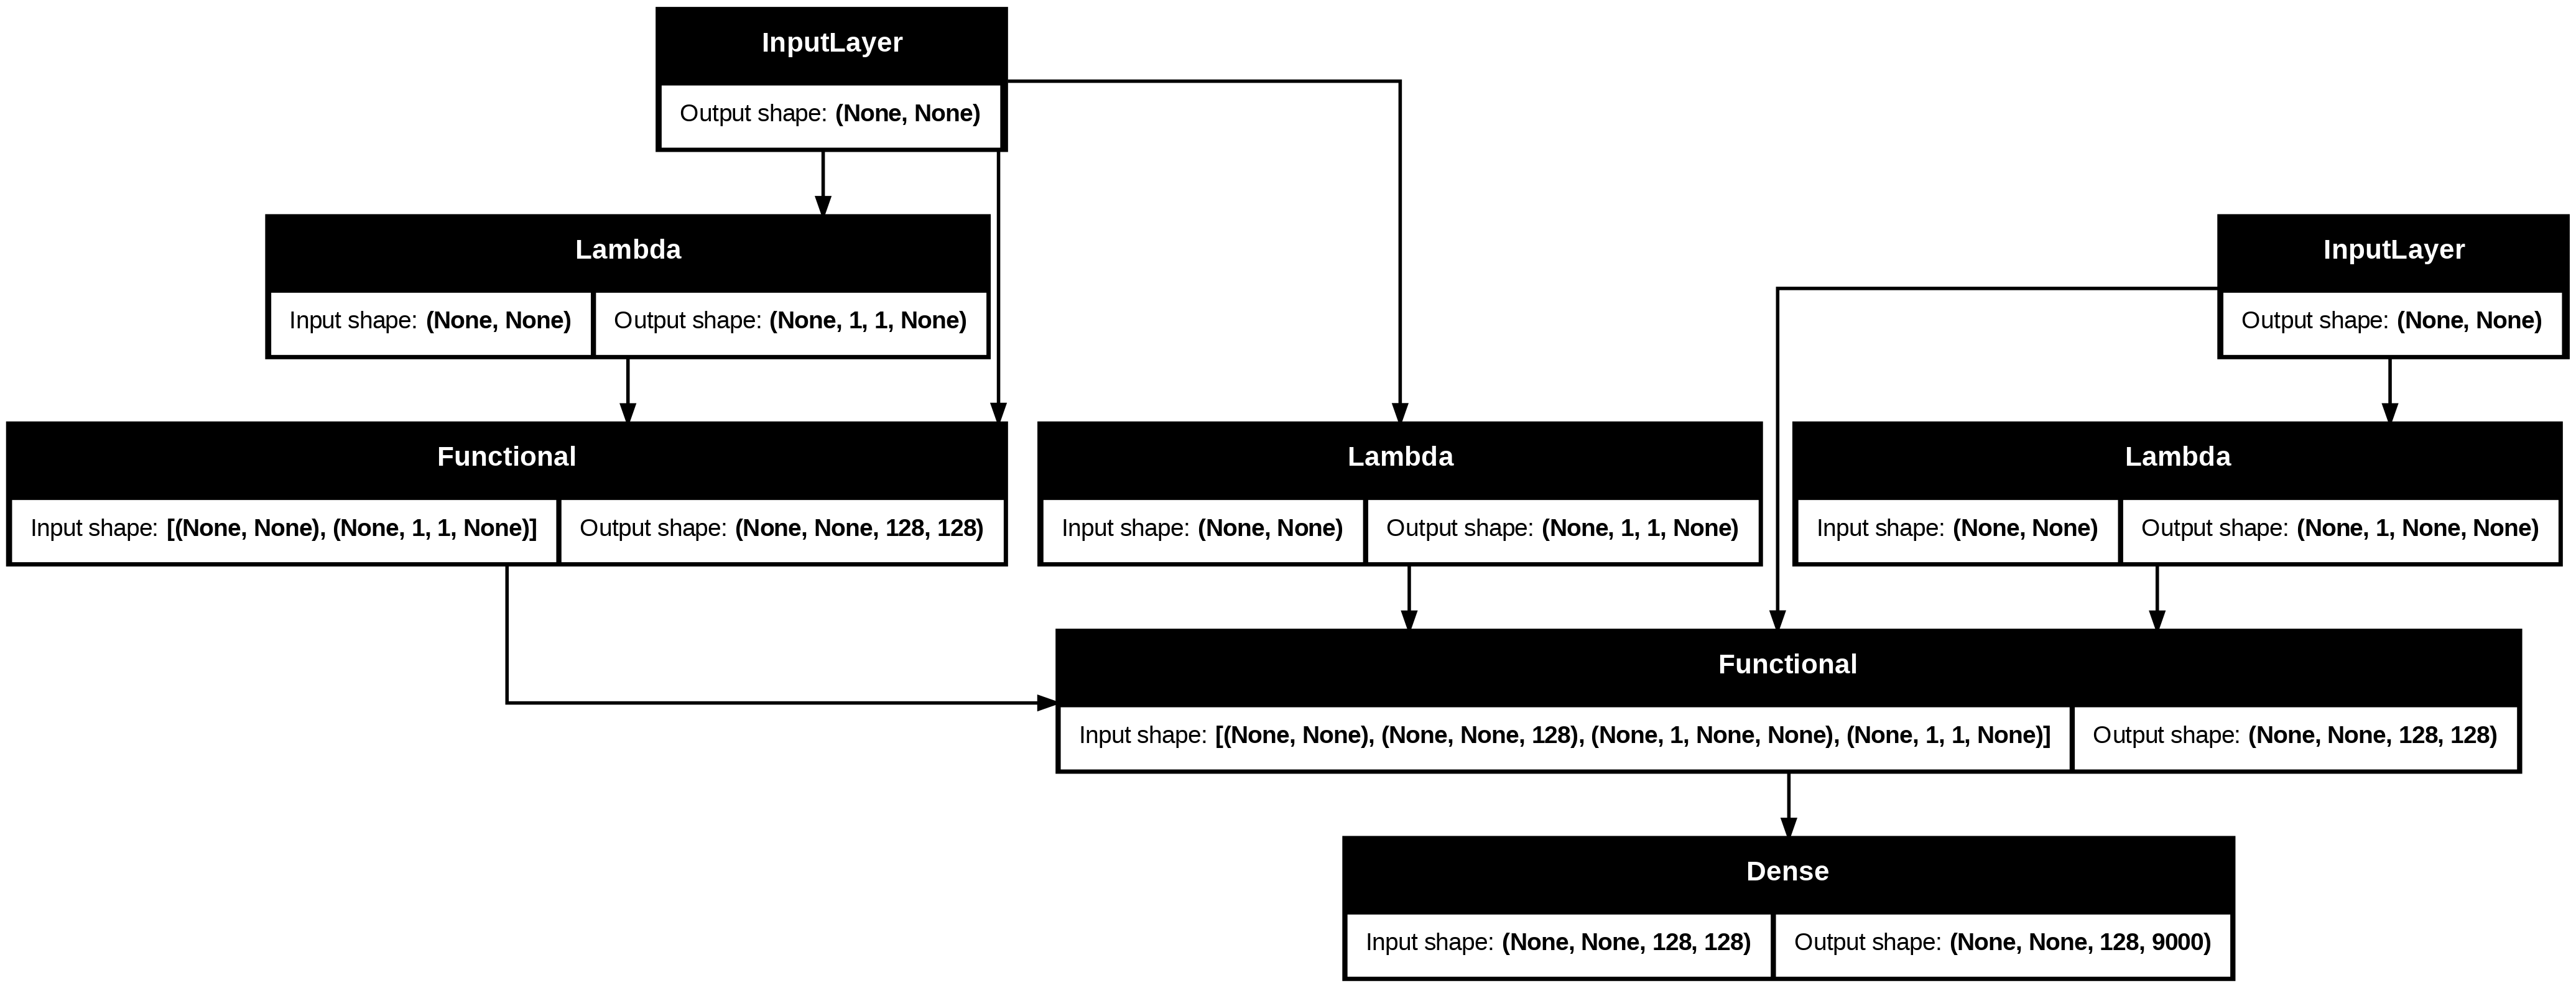

In [45]:
small_transformer = transformer(
    vocab_size = 9000,      # 사용할 단어 사전 크기입니다. 약 9,000개 단어를 처리합니다.
    num_layers = 4,         # 인코더와 디코더에 각각 4개의 레이어를 쌓습니다.
    dff = 512,              # Feed Forward 네트워크의 내부 차원(hidden size)입니다.
    d_model = 128,          # 임베딩 차원이며, 전체 모델의 차원입니다.
    num_heads = 4,          # Multi-Head Attention에서 사용되는 헤드 개수입니다.
    dropout = 0.3,          # 과적합을 방지하기 위한 드롭아웃 비율입니다.
    name="small_transformer" # 모델 이름을 지정합니다.
)

# 모델 구조를 시각적으로 저장합니다. (레이어 형태와 텐서 shape 출력)
tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)


### Transformer 구조 시각화 해석

- **입력 2개 흐름**
  - `inputs`: 인코더 입력(원본 문장)
  - `dec_inputs`: 디코더 입력(이전까지 생성된 문장)

- **마스크 처리**
  - 패딩 무시 + 미래 단어 차단(Look-Ahead Mask)

- **Encoder Functional Block**
  - 입력 문장을 문맥 벡터로 변환
  - 출력 shape: `(batch, seq_len, 128)`

- **Decoder Functional Block**
  - 문맥 + 이전 토큰 → 다음 토큰 정보 생성
  - 출력 shape: `(batch, seq_len, 128)`

- **최종 Dense Layer**
  - 각 위치에서 vocab(9000) 단어 확률 계산

# 4. 학습 준비 및 모델 학습

## 4-1. Loss Function (Cross Entropy + Padding Mask) 구성

이 함수는 트랜스포머 학습에 사용하는 손실 함수예요.

- SparseCategoricalCrossentropy로 **정답 토큰과 예측 확률**을 비교합니다
- `from_logits=True`로 설정해서 Softmax 이전 값(logits)을 그대로 사용합니다
- 패딩 토큰(0)은 학습에 영향을 주지 않도록 마스킹합니다 \
  → 실제 단어에서만 loss를 계산해요

최종적으로 실제 단어 위치들의 평균 손실을 반환하게 됩니다!


In [46]:
def loss_function(y_true, y_pred):
  # 정답 토큰을 (batch, seq_len) 형태로 reshape합니다.
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  # Cross Entropy Loss를 계산해요.
  # from_logits=True → softmax 이전 값 사용합니다.
  # reduction='none' → 모든 토큰별 loss를 개별적으로 계산합니다.
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  # 패딩 토큰(0)을 제외하기 위한 마스크입니다.
  # y_true가 0이 아닌 위치만 1로 남겨요.
  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)

  # 패딩 위치의 loss는 0이 되도록 곱합니다.
  loss = tf.multiply(loss, mask)

  # 마스킹된 loss 값들의 평균을 반환합니다.
  return tf.reduce_mean(loss)

## 4-2. 학습률 스케줄링 (Learning Rate Schedule)

트랜스포머 논문에서 사용한 **커스텀 학습률 스케줄**이에요.  

- 초반에는 **학습률을 점점 증가(warmup)** 시켜요  
- 이후에는 $1 / \sqrt{step}$  **형태로 감소**합니다  
- 모델 차원(`d_model`)에 따라 스케일을 자동 조정합니다  

이 방식은  
**초기 불안정한 시기를 부드럽게 지나고**,  
충분히 학습된 뒤에는 **학습률을 줄여 안정적으로 수렴**하도록 돕습니다.

---

**이해 포인트**

| 요소 | 설명 |
|---|---|
Warm-up | 학습 초반에 급격한 손실 변동을 방지해요 |
Decay | 일정 단계 이후 학습률을 점차 줄여요 |
`rsqrt(d_model)` | 모델 크기에 맞춰 학습률 스케일링 |
Transformer 논문 방식 | `"Attention is All You Need"` 공식 스케줄 |



In [47]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)   # 모델 차원을 float32로 변환합니다.
    self.warmup_steps = warmup_steps                  # 워밍업 스텝 개수입니다.

  def __call__(self, step):
    step = tf.cast(step, tf.float32)  # step을 float32로 변환해 연산 안정성을 올려요.

    # 트랜스포머 학습률 공식 구성 요소
    arg1 = tf.math.rsqrt(step)                      # 1 / √step : step이 커질수록 감소합니다.
    arg2 = step * (self.warmup_steps**-1.5)         # step / warmup_steps^(3/2) : 초기 증가 구간입니다.

    # 최종 학습률 = d_model^(-1/2) * min(arg1, arg2)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

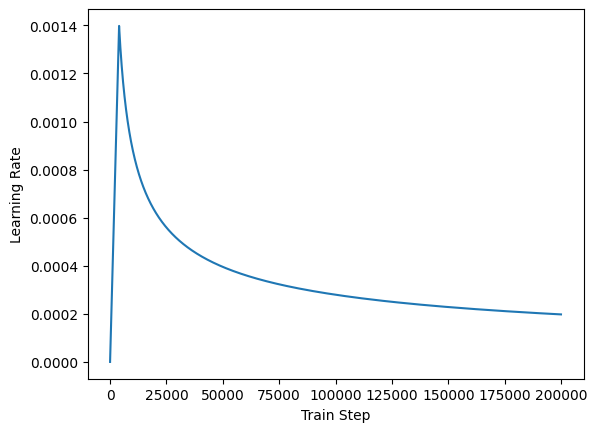

In [48]:
# 학습률 변화 곡선 시각화
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

- **초반 급상승 (Warm-up 구간)**
  - 학습 초기에는 학습률이 점점 증가합니다  
  - 모델이 갑자기 큰 변화에 흔들리지 않도록 천천히 학습을 시작해요

- **피크 이후 점진적 감소**
  - 일정 스텝이 지나면 학습률이 점차 감소합니다  
  - 학습이 안정되면서 세밀하게 최적화하도록 만듭니다

# 5. 챗봇 구현 & 결과 테스트

## 5-1. 데이터셋 다운로드

- 챗봇 학습용 데이터셋을 github에서 다운로드하고, 확인해봅니다.

In [49]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")

train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [50]:
print('챗봇 샘플의 개수 :', len(train_data))

챗봇 샘플의 개수 : 11823


In [54]:
# train_data의 결측치를 확인해봅시다.
print(train_data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


## 5-2. 데이터 전처리: 질문과 답변 분리

- 데이터셋에서 질문(Q)과 답변(A) 컬럼을 각각 리스트로 추출합니다
- 문장 내 구두점 뒤에 공백을 넣어 문장을 깔끔하게 정리해요  
  ex) `12시땡!` → `12시 땡 !`
- 불필요한 공백을 제거하여 모델이 학습하기 좋은 형태로 가공합니다

### Question 리스트 생성하기

In [55]:
questions = []
for sentence in train_data['Q']:
  # 구두점 앞뒤를 분리하여 문장을 더 읽기 쉽게 만듭니다
  # 예: "12시땡!" -> "12시 땡 !"
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

  # 좌우 공백 제거합니다
  sentence = sentence.strip()

  # 정리된 문장을 질문 리스트에 추가합니다
  questions.append(sentence)


### Answers 리스트 생성하기

In [56]:
answers = []
for sentence in train_data['A']:
  # 구두점 앞뒤를 분리해 문장을 정돈합니다
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

  # 좌우 공백 제거합니다
  sentence = sentence.strip()

  # 정리된 문장을 답변 리스트에 추가합니다
  answers.append(sentence)


In [57]:
len(questions)

11823

In [58]:
print(questions[:5])
print(answers[:5])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네']
['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .']


## 5-3. 서브워드 기반 토크나이저 생성

- `SubwordTextEncoder`를 사용해 **질문 + 답변 전체 코퍼스**로부터 단어 집합을 만듭니다  
- 단어를 통째로 나누는 대신 **단어를 더 작은 서브워드 단위로 분리**해요 \
  → 이를 통해 희귀 단어 처리에 강하게 만들고, OOV(미등록 단어) 문제를 줄입니다
- 시작 토큰과 종료 토큰을 별도로 부여하여 **문장 시작/끝을 Transformer가 명확히 인식**하도록 합니다


In [59]:
# 질문+답변 전체 코퍼스에서 서브워드 기반 토크나이저를 학습합니다.
# target_vocab_size=2**13 → 약 8192개의 서브워드를 목표로 만듭니다.
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# 문장 시작을 나타내는 토큰과 문장 종료를 나타내는 토큰을 지정합니다.
# vocab_size 바로 다음 숫자를 사용하여 고유한 특별 토큰으로 만들어요.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작/종료 토큰 2개가 추가되므로 전체 단어 집합 크기도 +2 합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2


In [60]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8178]
종료 토큰 번호 : [8179]
단어 집합의 크기 : 8180


In [61]:
# 서브워드 텍스트 인코더를 사용해 문장을 정수 시퀀스로 변환합니다.
# questions[20] → 21번째 질문 문장을 토크나이징합니다.
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [5766, 611, 3509, 141, 685, 3747, 849]


## 5-4. encode() & decode() 동작 확인

토크나이저가 정상적으로 동작하는지 테스트해봅니다.

- `encode()` : 문장 → 정수 시퀀스  
  모델이 학습할 수 있는 숫자 형태로 변환합니다
- `decode()` : 정수 시퀀스 → 문장  
  다시 사람이 읽을 수 있는 문장으로 되돌립니다

이 과정을 통해 토크나이저가  
**문장을 잘 쪼개고 다시 복원하는지** 확인합니다.


In [62]:
# 임의의 입력 문장을 sample_string에 저장합니다.
sample_string = questions[20]

# encode() : 텍스트 문장을 정수 시퀀스로 변환해요.
tokenized_string = tokenizer.encode(sample_string)
print('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스를 다시 문자열로 복원합니다.
original_string = tokenizer.decode(tokenized_string)
print('기존 문장: {}'.format(original_string))


정수 인코딩 후의 문장 [5766, 611, 3509, 141, 685, 3747, 849]
기존 문장: 가스비 비싼데 감기 걸리겠어


In [63]:
# 각 정수가 어떤 서브워드(단어 조각)와 대응되는지 병렬로 출력합니다.
# SubwordTextEncoder는 문장을 의미 단위의 서브워드로 분해합니다.
# 즉, 띄어쓰기 기준이 아니고 형태소 기반도 아니며, 자주 등장하는 단위로 학습된 토큰 단위예요.
for ts in tokenized_string:
  print('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5766 ----> 가스
611 ----> 비 
3509 ----> 비싼
141 ----> 데 
685 ----> 감기 
3747 ----> 걸리
849 ----> 겠어


## 5-5.  문장을 토큰화 & 모델 입력 형태로 변환

이 과정은 질문/답변 데이터를 모델이 학습할 수 있는 형태로 변환해요.

처리 과정은 다음과 같습니다:

1) 문장을 서브워드 토큰으로 인코딩  
2) 문장 앞에 `<START>`, 뒤에 `<END>` 토큰 붙이기  
3) 최대 길이(MAX_LENGTH=40)보다 짧으면 뒤에 패딩 추가 (`post` padding)  
4) 최종적으로 토큰 ID 시퀀스를 반환합니다

이 단계를 통해 Transformer가 **문장 구조를 이해**하고, **시작과 끝을 명확하게 구분**하도록 도와줘요.


In [66]:
# 최대 문장 길이를 40으로 정의합니다.
MAX_LENGTH = 40

# 문장을 토큰화 → 정수 인코딩 → 특수토큰 추가 → 패딩하는 함수입니다.
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # 각 문장을 토큰화 및 정수 인코딩하고,
    # 문장 앞에 START_TOKEN, 뒤에 END_TOKEN을 추가해요.
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)

  # 길이를 MAX_LENGTH 기준으로 맞추기 위해 패딩합니다.
  # padding='post' → 문장 끝에 0을 채워 넣어요.
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  # 패딩된 인코딩 결과 반환합니다.
  return tokenized_inputs, tokenized_outputs


In [67]:
# 준비된 질문과 답변 문장을 토큰화하고 패딩하여 모델 학습에 사용할 정수 시퀀스 형태로 변환합니다.
questions, answers = tokenize_and_filter(questions, answers)


In [68]:
print('질문 데이터의 크기 :', questions.shape)
print('답변 데이터의 크기 :', answers.shape)

질문 데이터의 크기 : (11823, 40)
답변 데이터의 크기 : (11823, 40)


In [69]:
# 0번째 샘플을 임의로 출력해봅니다.
print(questions[0])
print(answers[0])

[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [70]:
print('단어 집합의 크기(Vocab size): {}'.format(VOCAB_SIZE))
print('전체 샘플의 수(Number of samples): {}'.format(len(questions)))

단어 집합의 크기(Vocab size): 8180
전체 샘플의 수(Number of samples): 11823


## 5-6. Dataset 구성 (Teacher Forcing 포함)

- `tf.data.Dataset` API를 사용해 학습용 데이터를 구성합니다
- 질문(inputs)과 디코더 입력(dec_inputs), 정답 시퀀스를 함께 준비해요
- Teacher Forcing을 위해 디코더 입력과 정답을 한 토큰씩 어긋나게 만듭니다  
  - `dec_inputs`: `<START> ... second_last_token>`  
  - `labels`: `first_token ... <END>`
- 데이터는 섞고(shuffle) 배치 단위로 묶어줍니다

이 과정 덕분에 디코더는  
**이전 토큰을 보고 다음 토큰을 예측하는 방식으로 학습**합니다.

In [71]:
# 데이터셋 셔플 및 배치 구성을 위한 파라미터입니다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# TensorFlow Dataset으로 변환합니다.
# Teacher Forcing을 적용하기 위해 디코더 입력과 실제 정답 시퀀스를 구분해요.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,                # 인코더 입력 문장
        'dec_inputs': answers[:, :-1]       # 디코더 입력: 마지막 토큰 제외 (<END> 이전까지)
    },
    answers[:, 1:]                          # 정답 시퀀스: 첫 토큰 제거 (<START> 이후부터)
))

# 캐싱은 디버깅 중이라 주석 처리된 상태예요.
# dataset = dataset.cache()

# 학습 시 순서를 랜덤하게 섞어 모델이 패턴에 고정되지 않도록 합니다.
dataset = dataset.shuffle(BUFFER_SIZE)

# 데이터를 배치 단위로 묶습니다.
dataset = dataset.batch(BATCH_SIZE)

# 사전 로딩 및 성능 향상을 위한 prefetch 옵션 (디버깅 중이라 비활성)
# dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


In [72]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해봅니다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 됩니다.
print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거됩니다. 길이는 역시 39가 된네요.

[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3844   74 7894    1 8179    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


## 5-7. 모델 생성 & 학습

- 기존 세션을 초기화하여 메모리를 정리해요  
- 트랜스포머 모델의 핵심 구조를 결정하는 하이퍼파라미터를 설정합니다  
  - 레이어 수
  - 모델 차원
  - 헤드 수
  - FFN(Feed Forward Network) 차원
  - 드롭아웃 비율
- `transformer()` 함수로 학습에 사용할 모델을 생성합니다


In [73]:
tf.keras.backend.clear_session()   # 이전 텐서플로우 세션을 초기화하여 메모리를 정리합니다.

# Transformer 모델 구성에 필요한 Hyper-parameters 설정
NUM_LAYERS = 2     # 인코더/디코더 레이어 수입니다.
D_MODEL = 256      # 임베딩 및 모델의 차원 수예요.
NUM_HEADS = 8      # 멀티헤드 어텐션의 헤드 개수입니다.
DFF = 512          # Feed Forward Network 내부 차원이에요.
DROPOUT = 0.1      # 드롭아웃 비율입니다.

# 설정한 하이퍼파라미터를 이용해 Transformer 모델을 생성합니다.
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)


In [76]:
MAX_LENGTH = 40  # 모델이 다루는 최대 시퀀스 길이예요.

# Transformer 전용 커스텀 학습률 스케줄을 사용합니다 (warm-up 후 1/√step 감소합니다).
learning_rate = CustomSchedule(D_MODEL)

# Adam 옵티마이저를 설정합니다.
# - beta_1=0.9, beta_2=0.98: Transformer 논문에서 사용한 값입니다.
# - epsilon=1e-9: 매우 작은 상수로, 수치적으로 안정적인 업데이트를 돕습니다.
optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 라벨 텐서를 (batch_size, MAX_LENGTH - 1) 형태로 보정합니다.
  # 디코더 라벨은 <START>를 제외한 길이라서 -1을 적용합니다.
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  # 희소 정답 인덱스를 사용하는 정확도 지표를 계산합니다.
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# 모델을 컴파일합니다. 커스텀 스케줄이 적용된 Adam과 마스킹된 loss, 정확도를 사용해요.
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


In [85]:
# EPOCH 수는 50으로 설정합니다.
# 과제이니만큼, 본인이 원하는 EPOCHS를 조절해가며 테스트 해보세요 ~

EPOCHS = 25

# 모델을 학습(fit)시킵니다.
model.fit(dataset, epochs=EPOCHS)

Epoch 1/25


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("transformer_1/encoder_1/dropout_1/stateless_dropout/SelectV2:0", shape=(None, 40, 256, 256), dtype=float32). Expected shape (None, None, 256), but input has incompatible shape (None, 40, 256, 256)[0m

Arguments received by Functional.call():
  • inputs=['tf.Tensor(shape=(None, 40, 256, 256), dtype=float32)', 'tf.Tensor(shape=(None, 1, 1, 40), dtype=float32)']
  • training=True
  • mask=['None', 'None']
  • kwargs=<class 'inspect._empty'>

## 5-8. 모델 평가 & 테스트

- 입력 문장을 전처리하고 토큰으로 변환해요
- 디코더에 `<START>` 토큰을 주고 한 단어씩 생성합니다
- 가장 높은 확률(argmax)을 가진 토큰을 선택하는 **Greedy decoding** 방식이에요
- `<END>` 토큰이 나오면 문장 생성을 멈춥니다

`predict()` 함수는 `evaluate()`를 호출해  
입력 → 예측 결과 문장 형태로 출력해줍니다.


In [78]:
def evaluate(sentence):
  # 입력 문장을 전처리합니다 (소문자화, 공백 정리 등).
  sentence = preprocess_sentence(sentence)

  # 문장을 토큰으로 변환하고 START/END 토큰을 추가합니다.
  # axis=0 → 배치 차원을 추가해 (1, seq_len) 형태로 만들어요.
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더 입력의 시작은 START_TOKEN입니다.
  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더가 한 토큰씩 생성해요.
  for i in range(MAX_LENGTH):
    # 인코더 입력(sentence) + 디코더 입력(output)을 넣어 예측합니다.
    predictions = model(inputs=[sentence, output], training=False)

    # 마지막 시점의 예측만 가져와요.
    predictions = predictions[:, -1:, :]

    # 가장 높은 확률을 가진 토큰을 선택합니다 (Greedy decoding).
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # END 토큰 예측 시, 문장 생성을 종료합니다.
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 생성된 토큰을 output에 이어 붙여서
    # 다음 시점 디코더 입력으로 사용합니다.
    output = tf.concat([output, predicted_id], axis=-1)

  # 결과에서 배치 차원 제거합니다.
  return tf.squeeze(output, axis=0)


def predict(sentence):
  # Greedy decoding으로 문장을 생성합니다.
  prediction = evaluate(sentence)

  # 토큰 ID를 다시 문장으로 복원합니다.
  # tokenizer vocab 범위를 넘지 않는 토큰만 사용해요.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence


In [79]:
def preprocess_sentence(sentence):
  # 문장부호 앞뒤에 공백을 추가하여 토큰 분리를 쉽게 만들어요 (. , ! ? 등)
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

  # 양쪽 공백을 제거합니다 (입력 문장 정리)
  sentence = sentence.strip()

  return sentence  # 정제된 문장을 반환합니다


### 결과 출력해보기

In [80]:
# 짧은 구어체의 한국 input을 넣어 결과를 테스트해보세요!
# (학습 데이터와 비슷할수록 결과가 더 잘나옵니다)
output = predict('영화 볼래?')

ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input [[[[ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   ...
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]]

  [[ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   ...
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]]

  [[ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   ...
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]]

  [[ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   ...
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]]

  [[ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   ...
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]]

  [[ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   ...
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]
   [ 0.02014944  0.02162366  0.00208269 ...  0.00218941  0.04984507
    -0.01188927]]]]. Expected shape (None, None, 256), but input has incompatible shape (1, 6, 256, 256)[0m

Arguments received by Functional.call():
  • inputs=['tf.Tensor(shape=(1, 6, 256, 256), dtype=float32)', 'tf.Tensor(shape=(1, 1, 1, 6), dtype=float32)']
  • training=False
  • mask=['None', 'None']
  • kwargs=<class 'inspect._empty'>

In [ ]:
output = predict("고민이 있어")

Input: 고민이 있어
Output: 저는 고민이 없어요 .


In [ ]:
output = predict("너무 화가나")

Input: 너무 화가나
Output: 그럴수록 당신이 힘들 거예요 .


In [ ]:
output = predict("게임하고싶은데 할래?")

Input: 게임하고싶은데 할래?
Output: 그렇게 될 수 있어요 .


In [ ]:
output = predict("나 너 좋아하는 것 같아")

Input: 나 너 좋아하는 것 같아
Output: 호의인지 호감인지 헷갈리나요 ?


In [ ]:
output = predict("딥 러닝 자연어 처리를 잘 하고 싶어")

Input: 딥 러닝 자연어 처리를 잘 하고 싶어
Output: 하나씩 하나씩 해보세요 .
